Importing nessesary Libraries

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models,optimizers
import matplotlib.pyplot as plt
import os


Set GPU Instance

In [26]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

DEFINING VARIABLES

In [27]:
img_height = 224
img_width = 224
num_channels = 3
batch_size = 32
num_classes = 3
latent_dim = 100

DIRECTORY PATH

In [28]:
train_dir = 'C:\\Users\\Admin\\Documents\\osteoscarcoma_model_evaluation\\artifacts\\train'

LOAD IMAGES

In [29]:

datagen = ImageDataGenerator(
    rescale = 1/255.0
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 800 images belonging to 3 classes.


DEFINE GENERATOR

In [30]:
class Generator:
    def __init__(self, latent_dim,num_classes):
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.model = self.build_generator()

    def combine_noise_labels_gen(self,generator_input, labels_input):
        return layers.concatenate([generator_input,labels_input])
    
    def make_image_block(self,x,filters,kernel_size,strides=2):
        x = layers.Conv2DTranspose(filters,kernel_size,strides=strides,padding='same',use_bias=False,kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization(gamma_initializer='he_normal',beta_initializer='zeros')(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    
    def build_generator(self):
        generator_input = layers.Input(shape=(self.latent_dim,))
        labels_input = layers.Input(shape=(self.num_classes,))
        combined_input = self.combine_noise_labels_gen(generator_input,labels_input)

        x = layers.Dense(7*7*512, use_bias=False, kernel_initializer='he_normal')(combined_input)
        x = layers.Reshape((7, 7, 512))(x)
        x = layers.BatchNormalization(gamma_initializer='he_normal',beta_initializer='zeros')(x)
        x = layers.LeakyReLU(0.2)(x)

        x = self.make_image_block(x, 512, 5)
        x = self.make_image_block(x, 256, 3)
        x = self.make_image_block(x, 256, 3)
        x = self.make_image_block(x, 64, 3)
        x = self.make_image_block(x, 32, 4)

        x = layers.Conv2DTranspose(3, 7, padding='same', activation='tanh', use_bias=False, kernel_initializer='he_normal')(x)

        generator = models.Model([generator_input, labels_input], x)

        return generator



GETTING GENERATOR SUMMARY (TEST)

In [31]:
test_gen = Generator(latent_dim,num_classes).model
test_gen.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 103)          0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_8 (Dense)                (None, 25088)        2584064     ['concatenate_4[0][0]']    

DEFINE CRITIC

In [32]:
class Critic:
    def __init__(self,input_shape,num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_critic()

    def combine_img_labels_critic(self,critic_input,labels_input):
        label_resized = layers.Reshape((1, 1, num_classes))(labels_input) 
        label_resized = tf.image.resize(label_resized, (self.input_shape[0], self.input_shape[1]))

        return layers.Concatenate(axis=-1)([critic_input, label_resized])
    
    def make_critic_block(self,x,filters,kernel_size=3,strides=2):
        x = layers.Conv2D(filters,kernel_size,strides=strides,padding='same',kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization(gamma_initializer='he_normal',beta_initializer='zeros')(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Dropout(0.5)(x)
        return x

    def build_critic(self):
        critic_input = layers.Input(shape=(self.input_shape))
        labels_input = layers.Input(shape=(self.num_classes,))
        combined_input = self.combine_img_labels_critic(critic_input,labels_input)

        x = self.make_critic_block(combined_input, 64, 3)
        x = self.make_critic_block(x, 128, 3)
        x = self.make_critic_block(x, 256, 3)
        x = self.make_critic_block(x, 512, 3)
        x = self.make_critic_block(x, 512, 3)

        x = layers.Flatten()(x)
        x = layers.Dense(120, activation='relu',kernel_initializer='he_normal')(x)
        x = layers.Dense(84, activation='relu',kernel_initializer='he_normal')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(1)(x)

        critic = models.Model([critic_input, labels_input], x)
        return critic



GETTING CRITIC SUMMARY (TEST)

In [33]:
critic_test = Critic(input_shape=(224,224,3),num_classes=num_classes).model
critic_test.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 3)]          0           []                               
                                                                                                  
 reshape_5 (Reshape)            (None, 1, 1, 3)      0           ['input_12[0][0]']               
                                                                                                  
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.resize_2 (TFOpLambda)  (None, 224, 224, 3)  0          ['reshape_5[0][0]']        

To display the images by generator

In [34]:
class_names = train_generator.class_indices.keys()
print(class_names)

dict_keys(['Non-Tumor', 'Non-Viable-Tumor', 'Viable'])


In [35]:
def generate_and_display_images(generator, epoch, latent_dim=latent_dim, class_names=class_names):
    plt.figure(figsize=(10, 10))
    for class_label, class_name in enumerate(class_names):

        # Create a one-hot encoded label for the current class
        label = tf.one_hot([class_label], num_classes)

        # Generate a fake image using random noise and the one-hot encoded label
        noise = tf.random.normal(shape=(1, latent_dim))
        generate_image = generator([noise, label], training=False)

        # Plot the generated image
        plt.subplot(1, num_classes, class_label + 1)
        # Generated image pixels will be in range[-1,1] but imshow in matplotlib expects them between[0,1] so,
        plt.imshow((generate_image[0] * 0.5 + 0.5).numpy())
        plt.title(class_name)
        plt.axis("off")

    plt.suptitle("Generated Images at Epoch {}".format(epoch))
    
    # Adjust spacing between subplots
    plt.subplots_adjust(top=0.85, wspace=0.3)
    
    plt.show()


TRAINING CONSTANTS

In [36]:
c_lambda = 10
num_epochs = 10000
learning_rate = 0.0002
critic_train_steps = 5
beta_1 = 0.5
beta_2 = 0.999


WASSERSTEIN LOSSES

In [37]:
def compute_generator_loss(critic_fake_score):
    # critic_fake_score : the critic's scores of the fake images
    gen_loss = -tf.reduce_mean(critic_fake_score)
    return gen_loss

def compute_critic_loss(critic_fake_score,critic_real_score,gradient_penality,c_lambda=c_lambda):
    # critic_fake_score : the critic's scores of the fake images
    # critic_real_score : the critic's scores of the real images
    # gradient_penality : the unweighted gradient penalty
    # c_lambda: the current weight of the gradient penalty (hyperparameter usually initialized to 10)

    critic_loss = tf.reduce_mean(critic_fake_score) - tf.reduce_mean(critic_real_score) + c_lambda * gradient_penality
    return critic_loss

    

GRADIENT PENALITY

1) Compute Gradient with respect to images
2) Compute Gradient Penality given the gradient

-  The gradient is computed by first creating a mixed image.
-  This is done by Weighing fake and real images using a parameter (epsilon) and adding them together, we will get an intermediate mixed image
-  Get the critics output on the mixed image (crictic score)
-  Compute the gradient of critic's score on mixed images.

In [38]:
def get_gradient(critic, real, fake, labels_one_hot, epsilon):
    # critic : The critic model
    # real : batch of real images
    # fake : batch of fake images
    # epsilon : a vector of the uniformly random proportions of real/fake per mixed image

    with tf.GradientTape() as tape:
        mixed_images = (real * epsilon) + (fake * (1 - epsilon))
        tape.watch(mixed_images)
        mixed_score = critic([mixed_images, labels_one_hot])
        # print(mixed_score)
        
    gradient_mixed = tape.gradient(mixed_score, mixed_images)
    # print(gradient_mixed)
    return gradient_mixed

In [39]:
def compute_gradient_penalty(gradient):
    # gradient : gradient of the critic score with respect to mixed images

    gradient = tf.reshape(gradient,(tf.shape(gradient)[0],-1))
    gradient_norm = tf.norm(gradient,ord=2,axis=1)

    penalty = tf.reduce_mean((gradient_norm - 1)**2)

    return penalty

GETTING GENERATOR AND CRITIC INSTANCES

In [40]:
with tf.device('/GPU:0'):
    generator = Generator(latent_dim=latent_dim, num_classes=num_classes).model
    critic = Critic(input_shape=(img_height, img_width, num_channels), num_classes=num_classes).model

DEFINING OPTIMIZERS FOR GENERATOR AND CRITIC

In [41]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, beta_2)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1, beta_2)

MODEL CHECK POINT INITIALIZATION

In [42]:
# Define the base directory for checkpoints
checkpoint_path = 'C:\\Users\\Admin\\Documents\\osteoscarcoma_model_evaluation\\artifacts\\gan_checkpoints'

In [43]:

# Create directory for generator checkpoints
checkpoint_path_gen = os.path.join(checkpoint_path, 'generator')
os.makedirs(checkpoint_path_gen, exist_ok=True)

# Define checkpoint file prefix
checkpoint_prefix_gen = os.path.join(checkpoint_path_gen, 'ckpt.weights.h5')

# Define the checkpoint callback for the generator
checkpoint_callback_gen = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix_gen, save_weights_only=True, save_best_only=True)


In [44]:
checkpoint_path_critic = os.path.join(checkpoint_path,'critic')
os.makedirs(checkpoint_path_critic, exist_ok=True)

checkpoint_prefix_critic = os.path.join(checkpoint_path_critic, 'ckpt.weights.h5')

checkpoint_callback_critic = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix_critic, save_weights_only=True, save_best_only=True)

TRAINING

In [45]:
current_step = 0
display_step = 500
generator_losses = []
critic_losses = []
generator_losses_epoch = []
critic_losses_epoch = []

In [46]:
min_generator_loss = float('inf')
min_discriminator_loss = float('inf')

In [ ]:
generator.load_weights("C:\\Users\\Admin\\Documents\\osteoscarcoma_model_evaluation\\artifacts\\gan_checkpoints\\generator\\ckpt.weights.h5")
critic.load_weights("C:\\Users\\Admin\\Documents\\osteoscarcoma_model_evaluation\\artifacts\\gan_checkpoints\\critic\\ckpt.weights.h5")

Epoch 20, step 500: Generator loss: 148233.6616797108, critic loss: -1100437.9662665215
Epoch 40, step 1000: Generator loss: 2645593.33475, critic loss: -14663656.465


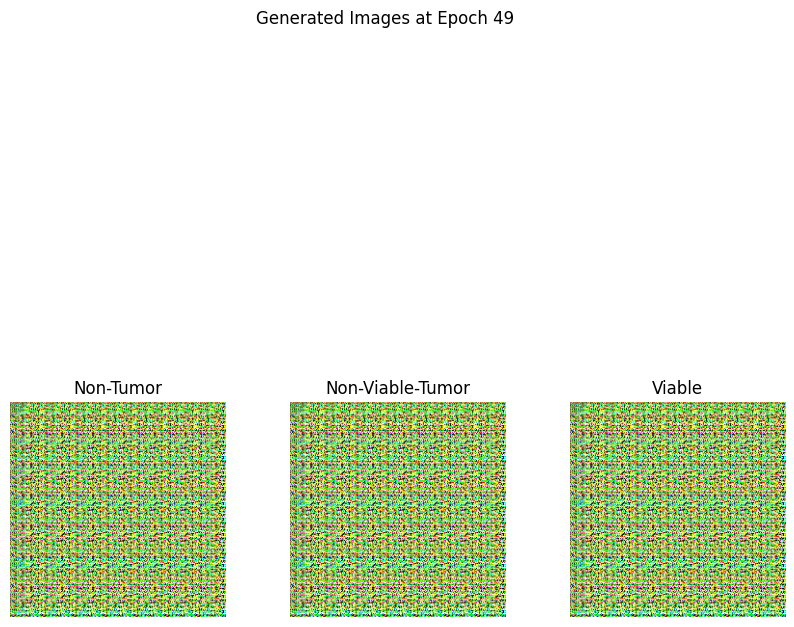

Epoch 60, step 1500: Generator loss: 9738876.606, critic loss: -60620730.58
Epoch 80, step 2000: Generator loss: 20479995.646, critic loss: -110216372.652


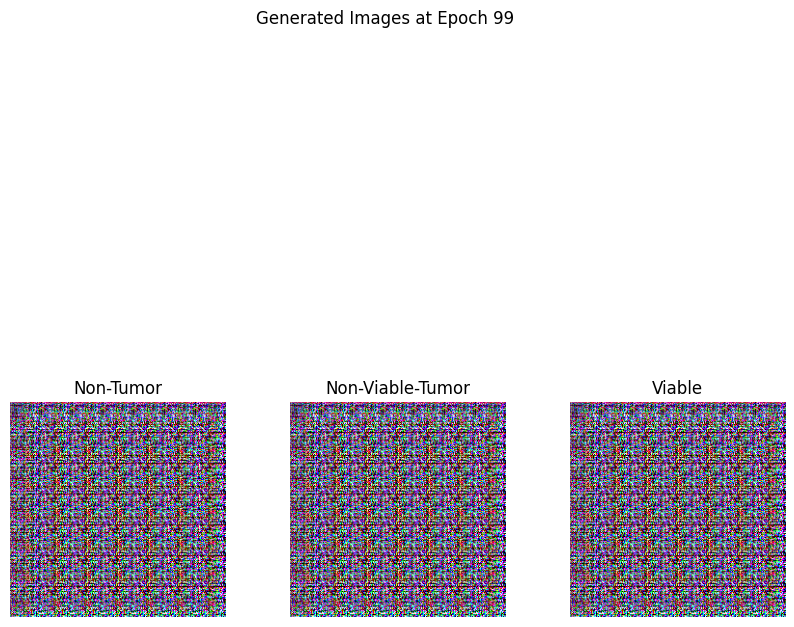

Epoch 100, step 2500: Generator loss: 40634025.948, critic loss: -81321127.0160625
Epoch 120, step 3000: Generator loss: 46732233.512, critic loss: -289770046.72


In [47]:
for epoch in range(num_epochs):
    for batch in range(len(train_generator)):
        with tf.device('/GPU:0'):
            # Load data onto GPU
            real_images_batch, labels = train_generator.__next__()
            real_images_batch = tf.convert_to_tensor(real_images_batch)
            one_hot_labels = tf.one_hot(tf.argmax(labels, axis=1), num_classes)

        mean_iter_critic_loss = 0
        for step in range(critic_train_steps):
            # Update Critic
            with tf.device('/GPU:0'), tf.GradientTape() as critic_tape:
                fake_noise = tf.random.normal(shape=(batch_size, latent_dim))
                generated_images = generator([fake_noise, one_hot_labels])

                critic_fake_predictions = critic([generated_images, one_hot_labels], training=True)
                critic_real_predictions = critic([real_images_batch, one_hot_labels], training=True)

                epsilon = tf.random.uniform((batch_size, 1, 1, 1))
                gradient_mix = get_gradient(critic=critic, real=real_images_batch, fake=generated_images, labels_one_hot=one_hot_labels, epsilon=epsilon)
                gradient_penalty = compute_gradient_penalty(gradient_mix)
                critic_loss = compute_critic_loss(critic_fake_score=critic_fake_predictions, critic_real_score=critic_real_predictions, gradient_penality=gradient_penalty, c_lambda=c_lambda)

            # Update gradients and weights for Critic
            critic_gradients = critic_tape.gradient(critic_loss, critic.trainable_variables)
            critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))
            mean_iter_critic_loss += critic_loss / critic_train_steps

        # Critic Loss
        critic_losses.append(mean_iter_critic_loss.numpy())

        # Update Generator
        with tf.device('/GPU:0'), tf.GradientTape() as generator_tape:
            fake_noise_2 = tf.random.normal(shape=(batch_size, latent_dim))
            generated_images_2 = generator([fake_noise_2, one_hot_labels], training=True)
            critic_fake_predictions_2 = critic([generated_images_2, one_hot_labels])
            generator_loss = compute_generator_loss(critic_fake_score=critic_fake_predictions_2)

        # Update weights for Generator
        generator_gradients = generator_tape.gradient(generator_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

        # Generator Loss
        generator_losses.append(generator_loss.numpy())

        # Compute mean losses for the epoch
        generator_loss_epoch = sum(generator_losses[-len(train_generator):]) / len(train_generator)
        critic_loss_epoch = sum(critic_losses[-len(train_generator):]) / len(train_generator)

        # Append mean losses to the lists
        generator_losses_epoch.append(generator_loss_epoch)
        critic_losses_epoch.append(critic_loss_epoch)

        # Display Progress
        if current_step % display_step == 0 and current_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            critic_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {current_step}: Generator loss: {gen_mean}, critic loss: {critic_mean}")

        current_step += 1

    # Save model checkpoints
    if generator_loss_epoch < min_generator_loss and critic_loss_epoch < min_discriminator_loss:
        generator.save_weights(checkpoint_prefix_gen)
        critic.save_weights(checkpoint_prefix_critic)

    # Generate and display images every 50 epochs
    if (epoch + 1) % 50 == 0:
        generate_and_display_images(generator=generator, epoch=epoch)

After training, load the best checkpoints

In [ ]:
generator.load_weights(checkpoint_prefix_gen)
critic.load_weights(checkpoint_prefix_critic)

Plot progress of generator and critic losses

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(generator_losses_epoch, label='Generator Loss', color='blue')
plt.plot(critic_losses_epoch, label='Critic Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Critic Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with tf.compat.v1.Session() as sess:
    result = sess.run(c)
    print(result)